In [1]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../Data/hindi_train.csv")
data

,Id,Heading,Summary,Article
0,hindi_2023_train_0,"गला दबाकर हत्या की; बॉडी बोरे में भरी, लोकल मा...",Kerala Minor Girl Rape Case - केरल के एर्नाकुल...,केरल के एर्नाकुलम जिले में 5 साल की बच्ची से र...
1,hindi_2023_train_1,तेलंगाना में 18 की जान गई; जम्मू-कश्मीर में बा...,इस साल मानसून सीजन में कई राज्यों में भारी तबा...,मानसून सीजन में हुई भारी बारिश ने कई राज्यों म...
2,hindi_2023_train_2,"राजस्थान सरकार बनाएगी कर्ज राहत आयोग, कोर्ट के...",चुनावी साल में राजस्थान सरकार किसानों को लुभान...,चुनावी साल में राजस्थान सरकार किसानों को लुभान...
3,hindi_2023_train_3,"3 से 7 अगस्त तक कर सकेंगे अप्लाय, प्राइस बैंड ...",Non-banking lender SBFC Finance's initial publ...,नॉन बैंकिग फाइनेंस कंपनी 'SBFC फाइनेंस लिमिटेड...
4,hindi_2023_train_4,"डाइनिंग टेबल पर कुकर-कड़ाही न सजाएं, चीन के खा...",स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...
...,...,...,...,...
21220,hindi_2022_11363,"MSP पर प्रधानमंत्री ने कमेटी बनाई, पराली जलाना...","कृषि मंत्री ने कहा, तीनों कृषि कानूनों को वापस...",नई दिल्ली: कृषि मंत्री नरेंद्र सिंह तोमर ने एम...
21221,hindi_2022_11364,"योगी सरकार ने 9 गेस्ट हाउस का नाम नदियों, धार्...",मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...,लखनऊ: उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने ...
21222,hindi_2022_11365,"Coronavirus से कुछ राहत, 7 लाख के नीचे आए एक्ट...",केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...,नई दिल्ली। कोरोना वायरस को लेकर कुछ राहत की बा...
21223,hindi_2022_11366,"वाराणसी गंगा नदी के किनारे सबसे साफ शहर बना, प...",लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...,नई दिल्ली: केंद्रीय शहरी विकास मंत्री हरदीप सि...


In [3]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)
print("Training Set:")
print(train_data.shape)
print("Validation Set:")
print(val_data.shape)

Training Set:
(18041, 4)
Validation Set:
(3184, 4)


In [4]:
import re

def preprocess_tokenize(text):
    # for removing punctuation from sentencesc
    text = str(text)
    # text = re.sub(r'(\d+)', r'', text) # remove numbers
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\u200d', '') #
    text = re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively
    text = re.sub(r"[&©@#ø;.~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!
    # text = re.sub(r"[‘’।:]", " ", str(text)) #removing other special characters
    # text = re.sub("([a-zA-Z])",' ',str(text)).lower() #removing all the single characters
    text = re.sub("(\s+)",' ',str(text)).lower() #removing extra spaces
    return text

train_text = [preprocess_tokenize(text) for text in train_data['Article']]
train_summary = [preprocess_tokenize(text) for text in train_data['Summary']]
train_heading = [preprocess_tokenize(text) for text in train_data['Heading']]
val_text = [preprocess_tokenize(text) for text in val_data['Article']]
val_summary = [preprocess_tokenize(text) for text in val_data['Summary']]
val_heading = [preprocess_tokenize(text) for text in val_data['Heading']]

In [5]:
import torch
from transformers import EncoderDecoderModel, AutoTokenizer, AutoModelForCausalLM,AutoModelForSeq2SeqLM, MT5ForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_encoder = AutoTokenizer.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum") #"aashay96/indic-gpt"
tokenizer_decoder = AutoTokenizer.from_pretrained("facebook/mbart-large-50", do_lower_case=False, use_fast=False, keep_accents=True)

decoder_model = MT5ForConditionalGeneration.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_decoder()
encoder_model =  AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_encoder()

model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model=encoder_model, decoder_pretrained_model_name_or_path="facebook/mbart-large-50")
model.config.decoder_start_token_id = tokenizer_encoder.pad_token_id
model.config.pad_token_id = tokenizer_encoder.pad_token_id
tokenizer_encoder.add_tokens(["<sum>"], special_tokens=True )
model = model.to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
model

EncoderDecoderModel(
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_fea

In [7]:
train = iter(train_heading[i] + train_text[i] for i in range(len(train_text)))
new_tokenizer = tokenizer_encoder.train_new_from_iterator(train, vocab_size=10000)
new_tokens = set(new_tokenizer.vocab) - set(tokenizer_encoder.vocab)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [8]:
len(new_tokenizer.vocab)

10000

In [9]:
tokenizer_encoder.add_tokens(list(new_tokens))

8261

In [10]:
model.decoder.resize_token_embeddings(len(tokenizer_encoder))
#model.resize_token_embeddings(len(tokenizer_encoder))
model.encoder.resize_token_embeddings(len(tokenizer_encoder))


Embedding(258362, 768)

In [44]:
model

EncoderDecoderModel(
  (encoder): MT5Stack(
    (embed_tokens): Embedding(258362, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_fea

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 2

In [12]:
def fine_tune(model, tokenizer_enc, tokenizer_dec, train_heading, train_text, train_summary, 
        optimizer, device, print_every=1000):
    model.train()
    model = model.to(device)
    total_loss = 0
    item_num = 0
    batch_loss = 0
    for heading, text, summary in zip(train_heading, train_text, train_summary):
        input = tokenizer_enc("<sum>" + heading + " " + text, return_tensors="pt", max_length=512, truncation=True)
        input_ids = input.input_ids.to(device)
        attention_mask = input.attention_mask.to(device)
        labels = tokenizer_dec(summary, max_length=120, truncation=True, return_tensors="pt")
        labels_input_ids = labels.input_ids.to(device)
        labels_attention_mask = labels.attention_mask.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask,  
                        labels=labels_input_ids, decoder_attention_mask=labels_attention_mask)
        loss = outputs.loss
        total_loss += loss.item()
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        item_num += 1
        if item_num % print_every == 0:
            print(f"Processed: {item_num}/{len(train_text)} Loss: {batch_loss/print_every}")
            batch_loss = 0
    return total_loss / len(train_text)
        

def evaluate(model, tokenizer_enc, tokenizer_dec, val_heading, val_text, val_summary, device):
    model.eval()
    model = model.to(device)
    total_loss = 0
    item_num = 0
    with torch.no_grad():
        for heading, text, summary in zip(val_heading, val_text, val_summary):
            input = tokenizer_enc("<sum>" + heading + " " + text, return_tensors="pt", max_length=512, truncation=True)
            input_ids = input.input_ids.to(device)
            attention_mask = input.attention_mask.to(device)
            labels = tokenizer_dec(summary, max_length=120, truncation=True, return_tensors="pt")
            labels_input_ids = labels.input_ids.to(device)
            labels_attention_mask = labels.attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,  
                        labels=labels_input_ids, decoder_attention_mask=labels_attention_mask)
            loss = outputs.loss
            total_loss += loss.item()
            item_num += 1
    return total_loss / len(val_text)

In [47]:
min_val_loss = None
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = fine_tune(model, tokenizer_encoder, tokenizer_decoder, train_heading, train_text, train_summary, 
                    optimizer, device, print_every=1000)
    print(f"==> Epoch {epoch + 1} Train Loss: {train_loss:.4f}")
    val_loss = evaluate(model, tokenizer_encoder, tokenizer_decoder, val_heading, val_text, val_summary, device)
    print(f"==> Epoch {epoch + 1} Validation Loss: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if min_val_loss is None or val_loss < min_val_loss:
        min_val_loss = val_loss
        model = model.to("cpu")
        torch.save(model.state_dict(), "summary_model_enc_dec_mT5_mbart.pth")

Processed: 1000/18041 Loss: 7.012580889701844
Processed: 2000/18041 Loss: 6.239558005332947
Processed: 3000/18041 Loss: 6.133524796962738
Processed: 4000/18041 Loss: 6.148110895156861
Processed: 5000/18041 Loss: 6.2159443981647495
Processed: 6000/18041 Loss: 6.139266798019409
Processed: 7000/18041 Loss: 6.236808681249618
Processed: 8000/18041 Loss: 6.192939320087433
Processed: 9000/18041 Loss: 6.284656039476395
Processed: 10000/18041 Loss: 6.28515184378624
Processed: 11000/18041 Loss: 6.279645591020584
Processed: 12000/18041 Loss: 6.365436891555786
Processed: 13000/18041 Loss: 6.295982372045517
Processed: 14000/18041 Loss: 6.3865146605968475
Processed: 15000/18041 Loss: 6.319561932563782
Processed: 16000/18041 Loss: 6.297333406686783


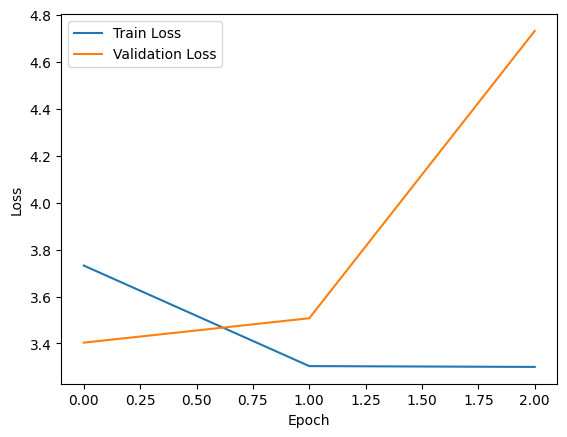

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
ind = 0
head_text = val_heading[ind]
article_text = val_text[ind]
summary_text = val_summary[ind]
inputs = tokenizer_encoder("<sum>" + head_text + " " + article_text, return_tensors="pt", max_length=1024, truncation=True).to(device)
labels = tokenizer_decoder(summary_text, max_length=240, truncation=True, return_tensors="pt").to(device)

outputs = model(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, labels=labels.input_ids, decoder_attention_mask=labels.attention_mask)
outputs.loss

tensor(4.8917, device='cuda:0', grad_fn=<NllLossBackward0>)

In [31]:
ind = 0
head_text = val_heading[ind]
article_text = val_text[ind]
summary_text = val_summary[ind]

input_ids = tokenizer_encoder("<sum>" + head_text + article_text, max_length=1024, truncation=True, return_tensors="pt").to(device)
outputs = model.generate(inputs=input_ids.input_ids, attention_mask=input_ids.attention_mask, decoder_start_token_id=model.config.decoder_start_token_id, num_beams=4)
summary = tokenizer_decoder.decode(outputs[0], skip_special_tokens=True, predict_with_generate=True)
print(outputs)
print("Summary:", summary)

tensor([[     0,      0,      6, 183319,  16285,      4,      4,      4,      4,
              4,      4,      4,      2]], device='cuda:0')
Summary: Завдяки цьому,,,,,,,


# Load the saved Model

In [32]:
import torch
from transformers import EncoderDecoderModel, AutoTokenizer, AutoModelForCausalLM,AutoModelForSeq2SeqLM, MT5ForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the tokenizer and model for encoder and decoder
tokenizer_encoder = AutoTokenizer.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum") #"aashay96/indic-gpt"
tokenizer_decoder = AutoTokenizer.from_pretrained("facebook/mbart-large-50", do_lower_case=False, use_fast=False, keep_accents=True)

# Load the pre-trained model for encoder and decoder
decoder_model = MT5ForConditionalGeneration.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_decoder()
encoder_model =  AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_encoder()

# Initialize the encoder-decoder model
loaded_model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model=encoder_model, decoder_pretrained_model_name_or_path="facebook/mbart-large-50")
loaded_model.config.decoder_start_token_id = tokenizer_encoder.pad_token_id
loaded_model.config.pad_token_id = tokenizer_encoder.pad_token_id
tokenizer_encoder.add_tokens(["<sum>"], special_tokens=True )
loaded_model = loaded_model.to(device)

# Add the new tokens to the tokenizer
train = iter(train_heading[i] + train_text[i] for i in range(len(train_text)))
new_tokenizer = tokenizer_encoder.train_new_from_iterator(train, vocab_size=10000)
new_tokens = set(new_tokenizer.vocab) - set(tokenizer_encoder.vocab)
tokenizer_encoder.add_tokens(list(new_tokens))

# Resize the token embeddings
loaded_model.decoder.resize_token_embeddings(len(tokenizer_encoder))
loaded_model.encoder.resize_token_embeddings(len(tokenizer_encoder))

# Load the pre-trained loaded_model
loaded_model.load_state_dict(torch.load("summary_model_enc_dec_mT5_mbart.pth"))

<All keys matched successfully>

In [33]:
ind = 4
head_text = val_heading[ind]
article_text = val_text[ind]
summary_text = val_summary[ind]

print("Heading:", head_text)
print("Article:", article_text)
print("Summary:", summary_text)
input_ids = tokenizer_encoder("<sum>" + head_text + article_text, max_length=512, truncation=True, return_tensors="pt").to(device)
outputs = loaded_model.generate(inputs=input_ids.input_ids, attention_mask=input_ids.attention_mask, 
                    decoder_start_token_id=loaded_model.config.decoder_start_token_id, max_length=40, 
                    num_beams=4, early_stopping=True)
summary = tokenizer_decoder.decode(outputs[0], skip_special_tokens=True, predict_with_generate=True)
print("Summary:", summary)

Heading: तिरंगा यात्रा के पहले रामलला के दर्शन करेंगे आम आदमी पार्टी के नेता
Article: अयोध्या: आम आदमी पार्टी (aap) के नेता मनीष सिसोदिया और संजय सिंह अयोध्या में 14 सितंबर से ‘तिरंगा यात्रा’ की शुरुआत करने से पहले रामलला का दर्शन करेंगे। बता दें कि पार्टी उत्तर प्रदेश विधानसभा चुनावों में 100 उम्मीदवारों के नाम घोषित करने की योजना बना रही है। आम आदमी पार्टी के राज्य अध्यक्ष सभाजीत सिंह ने कहा कि उत्तर प्रदेश में आगामी विधानसभा चुनावों के लिए 100 उम्मीदवारों की सूची अगले 15 दिनों में जारी की जाएगी। उन्होंने कहा कि पार्टी सभी 403 विधानसभा सीटों पर चुनाव लड़ेगी और किसी भी दल के साथ गठबंधन नहीं करेगी।‘हम भक्त की तरह रामलला की पूजा करेंगे’सभाजीत सिंह ने कहा कि दिल्ली के उपमुख्यमंत्री मनीष सिसोदिया और आम आदमी पार्टी के राज्यसभा सदस्य संजय सिंह अयोध्या में नवाब शुजाउद्दौला के संग्रहालय से ‘तिरंगा यात्रा’ शुरू करने से पहले रामजन्मभूमि में रामलला का दर्शन करेंगे। आम आदमी पार्टी ने पहले भारत की स्वतंत्रता की 75वीं वर्षगांठ पर इस तरह की यात्राएं लखनऊ, आगरा और नोएडा में आयोजित की थीं। सभाजीत सिंह

In [36]:
from tqdm import tqdm

def generate_summaries(headings, texts, tokenizer_encoder, tokenizer_decoder, model, data_name):
    generated_summary = []
    model = model.to(device)
    for i, item  in tqdm(enumerate(zip(headings, texts)), total=len(headings), desc=f"Generating Summaries for {data_name}"):
        head_text, article_text = item
        input_ids = tokenizer_encoder("<sum>" + head_text + article_text, max_length=512, truncation=True, return_tensors="pt").to(device)
        outputs = model.generate(inputs=input_ids.input_ids, attention_mask=input_ids.attention_mask, 
                        decoder_start_token_id=model.config.decoder_start_token_id, max_length=40, 
                        num_beams=4, early_stopping=True)
        summary = tokenizer_decoder.decode(outputs[0], skip_special_tokens=True, predict_with_generate=True)
        generated_summary.append(summary)
    return generated_summary

val_generated_summary = generate_summaries(val_heading, val_text, tokenizer_encoder, tokenizer_decoder,
                                loaded_model, "Validation Data")

Generating Summaries for Validation Data: 100%|██████████| 3184/3184 [18:19<00:00,  2.89it/s]


In [44]:
len(val_text), len(val_summary), len(val_generated_summary)

(3184, 3184, 3184)

In [45]:
from rouge import Rouge
import pandas as pd

rouge = Rouge()
scores = rouge.get_scores(val_generated_summary, val_summary, avg=True)
# rouge_scores = pd.DataFrame(scores).set_index(pd.Index(['rouge-1', 'rouge-2', 'rouge-l']))
rouge_scores = pd.DataFrame(scores).set_index([['recall','precision','f-measure']])
rouge_scores

,rouge-1,rouge-2,rouge-l
recall,0.032441,0.002557,0.031978
precision,0.131672,0.009812,0.129792
f-measure,0.051515,0.004009,0.050779


In [39]:
import plotly.express as px

fig = px.bar(rouge_scores*100, x=rouge_scores.index, y=rouge_scores.columns,
             barmode='group',
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })

fig.update_layout(width=650,
                  height=400,
                  title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

In [46]:
from bert_score import score

def calculate_bert_score(predicted_corpus, reference_corpus):
    p, r, f1 = score(predicted_corpus, reference_corpus, lang="de")
    return p.mean().item(), r.mean().item(), f1.mean().item()

bert_score_val = calculate_bert_score(val_generated_summary, val_summary)
print(f'BERT Scores:')
print(f'Precision in BERT Score: {bert_score_val[0]}')
print(f'Recall in BERT Score: {bert_score_val[1]}')
print(f'F1 Score in BERT Score: {bert_score_val[2]}')

BERT Scores:
Precision in BERT Score: 0.6294885277748108
Recall in BERT Score: 0.5959233045578003
F1 Score in BERT Score: 0.6121293306350708


In [41]:
[x for x in val_summary][:10]

['उत्तर प्रदेश के मथुरा जिले में यमुना एक्सप्रेस-वे पर आधा दर्जन बदमाशों ने दिल्ली से हमीरपुर जा रही निजी बस में सवारी के रूप में चढ़कर उसे बंधक बना लिया और तकरीबन सभी सवारियों से लाखों रुपये का सामान लूट किया।',
 'शनिवार की दोपहर करीब एक बजे सैकड़ों लोगों की मौजूदगी में मंत्री सुरेश राणा के पिता ठाकुर रणवीर सिंह का अंतिम संस्कार किया गया।',
 'up bhadohi bahubali ex-mla vijay mishra इस वक्त विजय मिश्रा, उनका बेटा विष्णु मिश्रा, भतीजा मनीष मिश्रा जेल में बंद हैं। इन सबकी करोड़ों रुपए की संपत्ति जब्त हो चुकी है।',
 'पिछले दो महीनों से मैं ये लगातार कह रहा हूं कि किसानों के आंदोलन में असामाजिक तत्वों और राजनीतिक कार्यकर्ताओं ने घुसपैठ की है।',
 'आम आदमी पार्टी ने पहले भारत की स्वतंत्रता की 75वीं वर्षगांठ पर इस तरह की यात्राएं लखनऊ, आगरा और नोएडा में आयोजित की थीं।',
 "अमीषा पटेल जल्द ही सनी देओल के साथ फिल्म गदर 2 में नजर आएंगी। हाल ही में उन्होंने मीडिया से बॉलीवुड के घटते हुए चार्म और हीरोइनों को ऑफर हो रहे रोल पर बात की। उन्होंने बॉक्स-ऑफिस पर बॉलीवुड फिल्मों के पिछड़ने पर भी अपनी heroin

In [42]:
[x for x in val_generated_summary][:10]

['प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोविड-19 कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।',
 'प्रधानमंत्री नरेंद्र मोदी कोरोना के मामले कोविड-19ों के मामले कोरोना के मामलेक्रम।']

In [43]:
[x for x in val_text][:10]

['मथुरा: उत्तर प्रदेश के मथुरा जिले में यमुना एक्सप्रेस-वे पर आधा दर्जन बदमाशों ने दिल्ली से हमीरपुर जा रही निजी बस में सवारी के रूप में चढ़कर उसे बंधक बना लिया और तकरीबन सभी सवारियों से लाखों रुपये का सामान लूट किया। घटना की जानकारी मिलने पर आगरा रेंज के पुलिस महानिरीक्षक समेत तमाम वरिष्ठ अधिकारी मौके पर पहुंचे। पुलिस बदमाशों की खोज में जुट गई है। पुलिस के मुताबिक, लूट की घटना उस समय घटी जब बीती रात दिल्ली से हमीरपुर के लिए निकली निजी बस करीब एक बजे नोएडा क्षेत्र से आगे मथुरा जिले की सुरीर कोतवाली क्षेत्र में पहुंची। पुलिस के मुताबिक, बदमाश सवारियों के रूप में बस में चढ़े थे और उन्होंने कुछ समय के बाद ही हथियारों के बल पर बस को बंधक बना लिया और सवारियों से नकदी व जेवर लूट लिए। घटना को अंजाम देने के बाद बदमाश जब बस से उतरकर फरार हो गए तो चालक ने पुलिस को सूचना दी। बस लूट की जानकारी मिलने पर आईजी नवीन अरोड़ा, एसएसपी डॉ गौरव ग्रोवर मौके पर पहुंच गए। एसएसपी डॉ गौरव ग्रोवर ने बताया कि बस की सवारियों से बदमाशों का हुलिया, बोली, चाल-ढाल आदि जानकारी जुटाने के बाद कई अलग-अलग टीमें उनकी तलाश में ल